In [3]:
import scanpy as sc
adata = sc.read_10x_h5("data/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5")
print(adata.var_names.is_unique)

False


C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [2]:
# 加载 SAE 模块
from SAE import SparseAutoencoder, train_sae, device

# 准备数据（示例，替换成你的 adata.X）
from sklearn.preprocessing import StandardScaler
import torch

X_dense = adata.X.toarray()
X_scaled = StandardScaler().fit_transform(X_dense)
data_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# 初始化模型（例：128维）
model = SparseAutoencoder(input_dim=X_scaled.shape[1], latent_dim=128)

# 训练模型
trained_model = train_sae(model, data_tensor, epochs=50, l1_weight=1e-4)

Using device: cuda


C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Epoch 1/50, Loss: 1081395562.6390
Epoch 2/50, Loss: 204.5821
Epoch 3/50, Loss: 206.6569
Epoch 4/50, Loss: 206.6741
Epoch 5/50, Loss: 206.7267
Epoch 6/50, Loss: 206.5856
Epoch 7/50, Loss: 206.6571
Epoch 8/50, Loss: 206.4193
Epoch 9/50, Loss: 206.5498
Epoch 10/50, Loss: 206.4440
Epoch 11/50, Loss: 206.5075
Epoch 12/50, Loss: 206.4086
Epoch 13/50, Loss: 206.3062
Epoch 14/50, Loss: 206.2882
Epoch 15/50, Loss: 206.2977
Epoch 16/50, Loss: 206.1906
Epoch 17/50, Loss: 206.1671
Epoch 18/50, Loss: 206.0995
Epoch 19/50, Loss: 206.0735
Epoch 20/50, Loss: 205.9797
Epoch 21/50, Loss: 206.0267
Epoch 22/50, Loss: 206.0094
Epoch 23/50, Loss: 205.7763
Epoch 24/50, Loss: 205.8650
Epoch 25/50, Loss: 205.8213
Epoch 26/50, Loss: 205.6932
Epoch 27/50, Loss: 205.6222
Epoch 28/50, Loss: 205.5831
Epoch 29/50, Loss: 205.5500
Epoch 30/50, Loss: 205.4696
Epoch 31/50, Loss: 205.4815
Epoch 32/50, Loss: 205.3966
Epoch 33/50, Loss: 205.2768
Epoch 34/50, Loss: 205.2876
Epoch 35/50, Loss: 205.2993
Epoch 36/50, Loss: 205

In [4]:
# 保证模型处于评估模式
trained_model.eval()

# 放到 GPU 上推理
with torch.no_grad():
    data_tensor = data_tensor.to(device)
    _, latent_all = trained_model(data_tensor)  # 只要编码结果 latent
    latent_all = latent_all.cpu().numpy()       # 移回 CPU，转为 numpy 格式


In [5]:
import numpy as np
import pandas as pd

# 保存为 .npy
np.save("latent_128.npy", latent_all)

# 或保存为 .csv，带上 index
latent_df = pd.DataFrame(latent_all, index=adata.obs_names)
latent_df.to_csv("latent_128.csv")


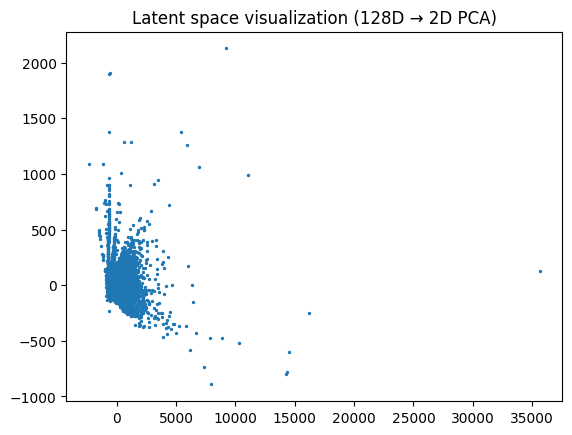

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_all)

plt.scatter(latent_2d[:,0], latent_2d[:,1], s=2)
plt.title("Latent space visualization (128D → 2D PCA)")
plt.show()


In [6]:
# 1. 读取聚类结果（修改路径为你所选的那个）
cluster_df = pd.read_csv("data/Parent_NGSC3_DI_PBMC_analysis/analysis/clustering/kmeans_2_clusters/clusters.csv")

# 2. 查看内容（应该有 Barcode 和 Cluster 两列）
print(cluster_df.head())

# 3. 设置 index 为 barcode（确保与 adata.obs_names 匹配）
cluster_df = cluster_df.set_index("Barcode")

# 4. 添加聚类信息到 adata.obs
adata.obs["kmeans_2"] = adata.obs_names.map(cluster_df["Cluster"])

              Barcode  Cluster
0  AAACCCACATAACTCG-1        2
1  AAACCCACATGTAACC-1        1
2  AAACCCAGTGAGTCAG-1        2
3  AAACCCAGTGCTTATG-1        1
4  AAACGAACAGTCAGTT-1        2


In [7]:
from sklearn.preprocessing import StandardScaler
latent_scaled = StandardScaler().fit_transform(latent_all)

latent_2d = PCA(n_components=2).fit_transform(latent_scaled)

In [8]:
colors = adata.obs["kmeans_2"].values

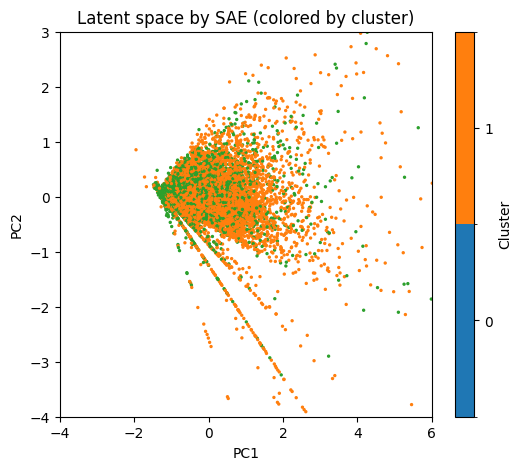

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np

# 设定离散类别数量（假设有 6 类，0~5）
num_classes = len(np.unique(colors))
boundaries = np.arange(-0.5, num_classes + 0.5, 1)
norm = BoundaryNorm(boundaries, ncolors=num_classes)

plt.figure(figsize=(6, 5))
sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=2, c=colors, cmap='tab10', norm=norm)
plt.xlim(-4, 6)
plt.ylim(-4, 3)
plt.title("Latent space by SAE (colored by cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(sc, ticks=np.arange(num_classes), label="Cluster")
plt.show()


In [17]:
model = SparseAutoencoder(input_dim=X_scaled.shape[1], latent_dim=3)
trained_model = train_sae(model, data_tensor, epochs=80, l1_weight=1e-4)

with torch.no_grad():
    _, latent = trained_model(data_tensor.to(device))
    latent_3d = latent.cpu().numpy()

Epoch 1/80, Loss: 49071784.7207
Epoch 2/80, Loss: 1702468.3490
Epoch 3/80, Loss: 77658.8375
Epoch 4/80, Loss: 12179.9555
Epoch 5/80, Loss: 5928.3372
Epoch 6/80, Loss: 3782.5865
Epoch 7/80, Loss: 2619.7982
Epoch 8/80, Loss: 1876.0933
Epoch 9/80, Loss: 1334.3903
Epoch 10/80, Loss: 944.2678
Epoch 11/80, Loss: 700.2213
Epoch 12/80, Loss: 554.9893
Epoch 13/80, Loss: 474.2342
Epoch 14/80, Loss: 415.2583
Epoch 15/80, Loss: 371.3538
Epoch 16/80, Loss: 336.2707
Epoch 17/80, Loss: 304.8627
Epoch 18/80, Loss: 288.2590
Epoch 19/80, Loss: 259.7459
Epoch 20/80, Loss: 238.9993
Epoch 21/80, Loss: 220.4255
Epoch 22/80, Loss: 208.8668
Epoch 23/80, Loss: 194.8183
Epoch 24/80, Loss: 189.6209
Epoch 25/80, Loss: 175.3730
Epoch 26/80, Loss: 166.0672
Epoch 27/80, Loss: 157.4420
Epoch 28/80, Loss: 147.5034
Epoch 29/80, Loss: 139.1171
Epoch 30/80, Loss: 135.1055
Epoch 31/80, Loss: 123.0876
Epoch 32/80, Loss: 113.7484
Epoch 33/80, Loss: 107.8534
Epoch 34/80, Loss: 102.2288
Epoch 35/80, Loss: 98.4995
Epoch 36/80,

In [21]:
# 1. 读取聚类结果（修改路径为你所选的那个）
cluster_df = pd.read_csv("data/Parent_NGSC3_DI_PBMC_analysis/analysis/clustering/kmeans_3_clusters/clusters.csv")

# 2. 查看内容（应该有 Barcode 和 Cluster 两列）
print(cluster_df.head())

# 3. 设置 index 为 barcode（确保与 adata.obs_names 匹配）
cluster_df = cluster_df.set_index("Barcode")

# 4. 添加聚类信息到 adata.obs
adata.obs["kmeans_3"] = adata.obs_names.map(cluster_df["Cluster"])

              Barcode  Cluster
0  AAACCCACATAACTCG-1        2
1  AAACCCACATGTAACC-1        1
2  AAACCCAGTGAGTCAG-1        2
3  AAACCCAGTGCTTATG-1        3
4  AAACGAACAGTCAGTT-1        2


In [23]:
colors = adata.obs["kmeans_3"].values

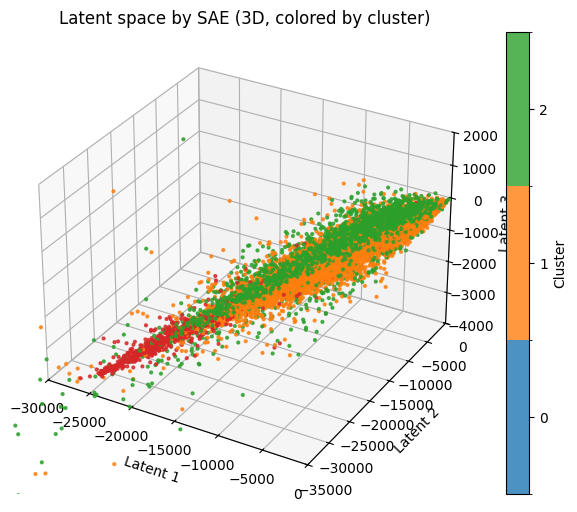

In [37]:
from mpl_toolkits.mplot3d import Axes3D  # 3D支持
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np

# 假设 latent_3d 是 SAE 输出的 shape=[n_cells, 3]
# colors 是 cluster label
num_classes = len(np.unique(colors))
boundaries = np.arange(-0.5, num_classes + 0.5, 1)
norm = BoundaryNorm(boundaries, ncolors=num_classes)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2],
    c=colors, cmap='tab10', norm=norm, s=4, alpha=0.8
)

ax.set_title("Latent space by SAE (3D, colored by cluster)")
ax.set_xlabel("Latent 1")
ax.set_ylabel("Latent 2")
ax.set_zlabel("Latent 3")
cb = fig.colorbar(sc, ticks=np.arange(num_classes))
cb.set_label("Cluster")

ax.set_xlim(-30000, 0)
ax.set_ylim(-35000, 0)
ax.set_zlim(-4000, 2000)

plt.show()

In [38]:
import plotly.express as px
import pandas as pd
import numpy as np

# 构建 DataFrame
df = pd.DataFrame(latent_3d, columns=["Latent1", "Latent2", "Latent3"])
df["Cluster"] = colors.astype(str)  # 保证是字符串类型，便于颜色分组

# 创建交互式图
fig = px.scatter_3d(
    df, x="Latent1", y="Latent2", z="Latent3",
    color="Cluster",
    title="Latent space by SAE (3D, interactive)",
    opacity=0.7
)

# 设置显示范围（与你之前 matplotlib 设置一致）
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-30000, 0], title="Latent 1"),
        yaxis=dict(range=[-35000, 0], title="Latent 2"),
        zaxis=dict(range=[-4000, 2000], title="Latent 3")
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# 点大小调小
fig.update_traces(marker=dict(size=2))

# 显示图像
fig.show()


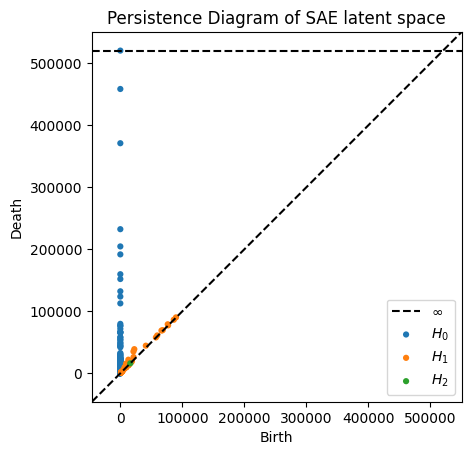

In [12]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams

# 只用前 500 个细胞（太大可能会卡）
latent_all = np.load("latent_128.npy")
subset = latent_all[:1000]

# 计算 persistent homology
result = ripser(subset, maxdim=2)  # 你也可以设置 maxdim=1，只分析群落和环
diagrams = result['dgms']

# 可视化
plot_diagrams(diagrams, show=True, title="Persistence Diagram of SAE latent space")


In [13]:
from collections import Counter

betti_counts = [len(diag) for diag in diagrams]
print(f"Betti numbers: H0={betti_counts[0]}, H1={betti_counts[1]}, H2={betti_counts[2]}")

Betti numbers: H0=1000, H1=59, H2=1


C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


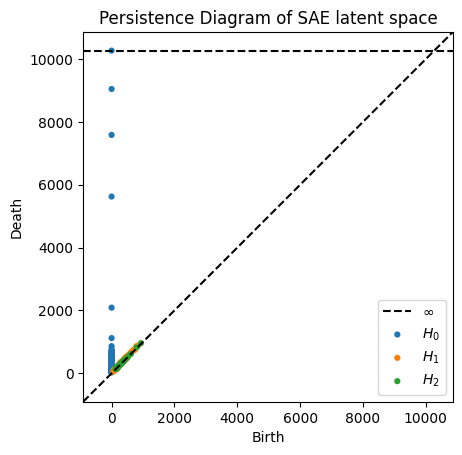

In [10]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams

# 只用前 500 个细胞（太大可能会卡）
subset = adata.X[:1000]

# 计算 persistent homology
result = ripser(subset, maxdim=2)  # 你也可以设置 maxdim=1，只分析群落和环
diagrams = result['dgms']

# 可视化
plot_diagrams(diagrams, show=True, title="Persistence Diagram of SAE latent space")

In [11]:
betti_counts = [len(diag) for diag in diagrams]
print(f"Betti numbers: H0={betti_counts[0]}, H1={betti_counts[1]}, H2={betti_counts[2]}")

Betti numbers: H0=1000, H1=532, H2=130


In [1]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from SAE import SparseAutoencoder, train_sae, device  # 保证你 SAE.py 结构正确
import os

def run_and_save_latent(adata, latent_dim, save_dir="latent_db"):
    os.makedirs(save_dir, exist_ok=True)

    # 预处理
    X_dense = adata.X.toarray()
    X_scaled = StandardScaler().fit_transform(X_dense)
    data_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    # 初始化 SAE 并训练
    model = SparseAutoencoder(input_dim=X_scaled.shape[1], latent_dim=latent_dim)
    trained_model = train_sae(model, data_tensor, epochs=50, l1_weight=1e-4)

    # 提取 latent 表达
    trained_model.eval()
    with torch.no_grad():
        latent_all = trained_model.encoder(data_tensor.to(device)).cpu().numpy()

    # 保存 latent 到 latent_db
    save_path = os.path.join(save_dir, f"latent_{latent_dim}.npy")
    np.save(save_path, latent_all)
    print(f"Saved latent to: {save_path}")


Using device: cuda


In [4]:
# 设置所有目标维度
dims_to_run = [512]

# 跑每个维度一次
for dim in dims_to_run:
    run_and_save_latent(adata, latent_dim=dim)


C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Epoch 1/50, Loss: 6861829450.7335
Epoch 2/50, Loss: 230.2385
Epoch 3/50, Loss: 232.8738
Epoch 4/50, Loss: 232.7841
Epoch 5/50, Loss: 232.5531
Epoch 6/50, Loss: 232.5975
Epoch 7/50, Loss: 232.6027
Epoch 8/50, Loss: 232.5683
Epoch 9/50, Loss: 232.6530
Epoch 10/50, Loss: 232.6342
Epoch 11/50, Loss: 232.4886
Epoch 12/50, Loss: 232.6377
Epoch 13/50, Loss: 232.5392
Epoch 14/50, Loss: 232.5989
Epoch 15/50, Loss: 232.6641
Epoch 16/50, Loss: 232.5183
Epoch 17/50, Loss: 232.3603
Epoch 18/50, Loss: 232.4072
Epoch 19/50, Loss: 232.3943
Epoch 20/50, Loss: 232.4917
Epoch 21/50, Loss: 232.3086
Epoch 22/50, Loss: 232.3263
Epoch 23/50, Loss: 232.4947
Epoch 24/50, Loss: 232.2801
Epoch 25/50, Loss: 232.3647
Epoch 26/50, Loss: 232.4162
Epoch 27/50, Loss: 232.2642
Epoch 28/50, Loss: 232.3247
Epoch 29/50, Loss: 232.2906
Epoch 30/50, Loss: 232.2614
Epoch 31/50, Loss: 232.2204
Epoch 32/50, Loss: 232.1545
Epoch 33/50, Loss: 232.1480
Epoch 34/50, Loss: 232.1473
Epoch 35/50, Loss: 232.1903
Epoch 36/50, Loss: 232

In [5]:
import os
import numpy as np
import pandas as pd
from ripser import ripser
from collections import defaultdict
import matplotlib.pyplot as plt

# 设置 latent 维度列表和文件夹路径
latent_dims = [512, 256, 128, 64, 32, 16, 8, 4, 2]
latent_dir = "latent_db"

# 存储 Betti 数结果
betti_results = defaultdict(dict)

# 遍历所有 latent 文件
for dim in latent_dims:
    file_path = os.path.join(latent_dir, f"latent_{dim}.npy")
    if os.path.exists(file_path):
        latent = np.load(file_path)
        subset = latent[:1000]  # 只取前 500 个样本
        result = ripser(subset, maxdim=2)
        diagrams = result['dgms']
        betti_counts = [len(dgm) for dgm in diagrams]
        betti_results[dim] = {
            "H0": betti_counts[0] if len(betti_counts) > 0 else 0,
            "H1": betti_counts[1] if len(betti_counts) > 1 else 0,
            "H2": betti_counts[2] if len(betti_counts) > 2 else 0,
        }
    else:
        print(f"文件不存在: {file_path}")

# 转换为 DataFrame 显示
df_betti = pd.DataFrame.from_dict(betti_results, orient="index")
df_betti = df_betti.sort_index()
display(df_betti)

,H0,H1,H2
2,1000,231,2
4,1000,344,34
8,1000,253,18
16,1000,102,2
32,1000,126,3
64,1000,154,5
128,1000,88,1
256,1000,46,2
512,1000,56,0


C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Laplace\AppData\Roaming\Python\Python313\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


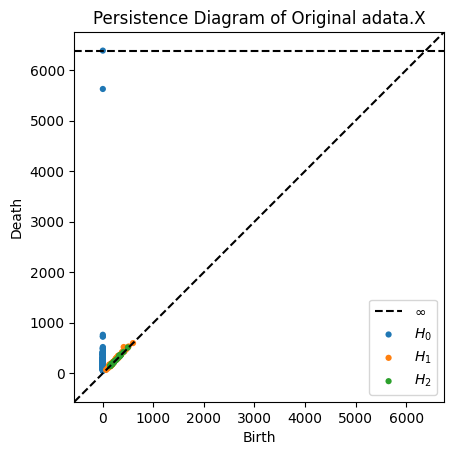

Betti numbers of adata.X: H0=500, H1=218, H2=48


In [2]:
import scanpy as sc
from ripser import ripser
from persim import plot_diagrams
import numpy as np

# 加载原始 adata（路径按需修改）
adata = sc.read_10x_h5("data/Parent_NGSC3_DI_PBMC_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

# 为避免过大导致崩溃，仅使用前 500 个细胞
subset = adata.X[:500].toarray()

# 计算 persistent homology
result = ripser(subset, maxdim=2)
diagrams = result['dgms']

# 可视化
plot_diagrams(diagrams, show=True, title="Persistence Diagram of Original adata.X")

# 输出 Betti 数量
betti_counts = [len(diag) for diag in diagrams]
print(f"Betti numbers of adata.X: H0={betti_counts[0]}, H1={betti_counts[1]}, H2={betti_counts[2]}")


In [9]:
adata.var


,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38
AC023491.2,ENSG00000278633,Gene Expression,GRCh38
AC007325.1,ENSG00000276017,Gene Expression,GRCh38
AC007325.4,ENSG00000278817,Gene Expression,GRCh38


In [4]:
import numpy as np, plotly.graph_objects as go

discrete_morse_skeleton

In [5]:
# ---------- 双螺旋点云 ----------
np.random.seed(1)
t  = np.linspace(-2*np.pi, 2*np.pi, 6000)
r  = 1.0
h  = 5.0 / (2*np.pi)           # 每圈爬升
x1, y1, z1 = r*np.cos(t),  r*np.sin(t),  h*t
x2, y2, z2 = r*np.cos(t+np.pi), r*np.sin(t+np.pi), h*t
pts = np.vstack([np.c_[x1,y1,z1], np.c_[x2,y2,z2]])
pts += np.random.randn(*pts.shape)*0.02            # 轻微噪声

In [6]:
pts

array([[ 1.03248691, -0.01223513, -5.01056344],
       [ 0.97853843,  0.0194029 , -5.04436383],
       [ 1.03488746, -0.01103466, -4.99028533],
       ...,
       [-1.0026014 ,  0.00590398,  4.96842617],
       [-1.02183591, -0.02245552,  5.01825404],
       [-1.00201995,  0.01476443,  4.99105494]], shape=(12000, 3))

In [ ]:

from dm_full import discrete_morse_graph, visualize_graph3d

G   = discrete_morse_graph(pts,
                           grid_res=512,
                           sigma=5,
                           visualize=False)  

KeyboardInterrupt: 

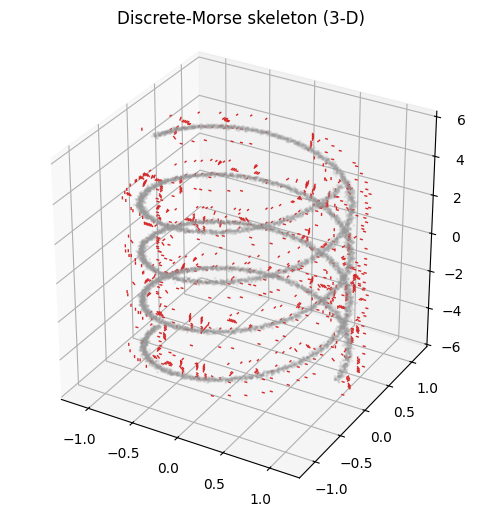

In [ ]:
import matplotlib.pyplot as plt
visualize_graph3d(G, pts)
plt.show()

In [1]:
import numpy as np
from dm_yw import yw_morse_skeleton
from dm_full import visualize_graph3d   # 之前的可视化

# 双螺旋 2×1000 点
theta = np.linspace(0, 6*np.pi, 2000)
x, y = np.cos(theta), np.sin(theta)
z = np.linspace(-6, 6, 2000)
pts = np.c_[x, y, z] + 0.02 * np.random.randn(2000, 3)

G = yw_morse_skeleton(pts,
                      grid_res=128,
                      sigma=1.5,
                      eps_cancel=0.03)

fig = visualize_graph3d(G, pts, s=4, lw=1.2)
fig.figure.show()


RuntimeError: 你的 Gudhi 版本不包含 coreduction_gvf() —— 请执行  pip install 'gudhi[core] --upgrade'  或使用之前的纯-Python 实现

In [ ]:
visualize_graph3d(G, pts, s=1)
plt.show()

In [2]:
from gudhi import CubicalComplex
cub = CubicalComplex(top_dimensional_cells=[0, 1, 2, 3])
gvf = cub.coreduction_gvf()
print(type(gvf))

AttributeError: 'gudhi.cubical_complex.CubicalComplex' object has no attribute 'coreduction_gvf'